In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import pandas as pd
import torch

In [2]:
import NeuMF
from config.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    DEFAULT_K,
    SEED,
)
import myutils
from ranking import (
    metrics,
    trn_val_tst,
)

In [3]:
myutils.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# DATA PREPARATION

In [5]:
DATA_NAME = "ml-100k"
DATA_PATH = f"./data/{DATA_NAME}.csv"
data = pd.read_csv(DATA_PATH)

In [6]:
data

,userId,movieId,rating,timestamp
0,1,0,4.0,964982703
1,1,2,4.0,964981247
2,1,5,4.0,964982224
3,1,43,5.0,964983815
4,1,46,5.0,964982931
...,...,...,...,...
100831,610,9416,4.0,1493848402
100832,610,9443,5.0,1493850091
100833,610,9444,5.0,1494273047
100834,610,9445,5.0,1493846352


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### COL

In [ ]:
COL_LIST = ['userId', 'movieId', 'rating', 'timestamp']

RE_COL_LIST = [
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_TIMESTAMP_COL,
]

data = data[COL_LIST]
data.columns = RE_COL_LIST

In [10]:
data

,userId,itemId,rating,timestamp
0,1,0,4.0,964982703
1,1,2,4.0,964981247
2,1,5,4.0,964982224
3,1,43,5.0,964983815
4,1,46,5.0,964982931
...,...,...,...,...
100831,610,9416,4.0,1493848402
100832,610,9443,5.0,1493850091
100833,610,9444,5.0,1494273047
100834,610,9445,5.0,1493846352


### LABEL

In [13]:
print(
    data[DEFAULT_USER_COL].nunique() == max(data[DEFAULT_USER_COL].unique()+1),
    data[DEFAULT_ITEM_COL].nunique() == max(data[DEFAULT_ITEM_COL].unique()+1),
    sep='\n'
)

False
True


In [14]:
kwargs = dict(
    data=data, 
    col_user=DEFAULT_USER_COL, 
    col_item=DEFAULT_ITEM_COL,
)

data, user_label, item_label = myutils.data.label_encoding(**kwargs)

### DESC

In [15]:
myutils.data.description(data)

number of user: 610
number of item: 9724
total interaction: 100836
mean interaction of user: 165
mean interaction of item: 10
interaction density: 1.7000 %


In [16]:
N_USERS = 610
N_ITEMS = 9724

### SPLIT

In [17]:
FILTER_BY = "user"
TRN_VAL_TST_RATIO = [0.7, 0.1, 0.2]
NEG_PER_POS = [4, 1, 99]
HOW_TO_LEARN = ['pairwise', 'pairwise', 'pointwise']
BATCH_SIZE = [32, 128, 32]

In [18]:
kwargs = dict(
    data=data,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
)

dataloader = trn_val_tst.NegativeSamplingDataloader(**kwargs)

kwargs = dict(
    filter_by=FILTER_BY,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS,
    how_to_learn=HOW_TO_LEARN,
    batch_size=BATCH_SIZE,
    seed=SEED,
    )

trn_loader, val_loader, tst_loader = dataloader.get(**kwargs)

# MODEL BUILDING

## Model

In [20]:
N_FACTORS = 16
LAMBDA_ = 0.1
HIDDEN = [64, 64, 32, 16]
DROPOUT = 0.2
MODEL_NAME = "NeuMF"

In [ ]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    hidden=HIDDEN,
    dropout=DROPOUT,
    name=MODEL_NAME,
)

model = NeuMF.MODEL.Module(**kwargs)

## Loop

In [ ]:
LR = 0.001
LAMBDA_ = 0.0001
N_EPOCHS = 10

In [23]:
kwarg = dict(
    model=model,
    lr=LR,
    lambda_=LAMBDA_,
    n_epochs=N_EPOCHS,
)

loop = NeuMF.LOOP.Module(**kwarg)
loop = loop.to(device)

# TRAIN

In [24]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
)

history = loop.train(**kwargs)

EPOCH 1 START ---->>>>


EPOCH 1/10 TRN: 100%|██████████| 2206/2206 [00:17<00:00, 124.66it/s]


TRN LOSS: 0.5357


EPOCH 1/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 315.34it/s]


VAL LOSS: 0.3642


EPOCH 2/10 TRN: 100%|██████████| 2206/2206 [00:16<00:00, 135.97it/s]


TRN LOSS: 0.3317


EPOCH 2/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 339.44it/s]


VAL LOSS: 0.3212


EPOCH 3/10 TRN: 100%|██████████| 2206/2206 [00:17<00:00, 125.80it/s]


TRN LOSS: 0.3070


EPOCH 3/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 307.35it/s]


VAL LOSS: 0.3170


EPOCH 4/10 TRN: 100%|██████████| 2206/2206 [00:18<00:00, 122.29it/s]


TRN LOSS: 0.2934


EPOCH 4/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 316.68it/s]


VAL LOSS: 0.3162


EPOCH 5/10 TRN: 100%|██████████| 2206/2206 [00:17<00:00, 124.77it/s]


TRN LOSS: 0.2645


EPOCH 5/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 316.86it/s]


VAL LOSS: 0.2902


EPOCH 6/10 TRN: 100%|██████████| 2206/2206 [00:17<00:00, 125.93it/s]


TRN LOSS: 0.2263


EPOCH 6/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 312.20it/s]


VAL LOSS: 0.2833


EPOCH 7/10 TRN: 100%|██████████| 2206/2206 [00:17<00:00, 124.86it/s]


TRN LOSS: 0.1974


EPOCH 7/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 308.08it/s]


VAL LOSS: 0.2887


EPOCH 8/10 TRN: 100%|██████████| 2206/2206 [00:17<00:00, 126.11it/s]


TRN LOSS: 0.1841


EPOCH 8/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 300.55it/s]


VAL LOSS: 0.2670


EPOCH 9/10 TRN: 100%|██████████| 2206/2206 [00:17<00:00, 128.40it/s]


TRN LOSS: 0.1750


EPOCH 9/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 278.84it/s]


VAL LOSS: 0.2823


EPOCH 10/10 TRN: 100%|██████████| 2206/2206 [00:17<00:00, 125.80it/s]


TRN LOSS: 0.1653


EPOCH 10/10 VAL: 100%|██████████| 79/79 [00:00<00:00, 298.66it/s]

VAL LOSS: 0.2863


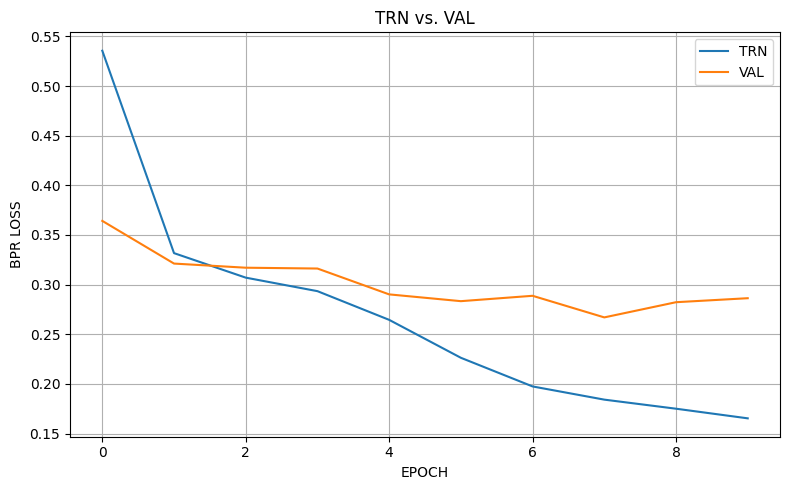

In [ ]:
myutils.visualization.plot_loss(history)

# TEST

In [29]:
result = loop.predict(tst_loader)

TST: 100%|██████████| 631/631 [00:03<00:00, 203.45it/s]


In [ ]:
kwargs = dict(
    origin=data,
    rating_true=result['true'],
    rating_pred=result['pred'],
    item_embed=model.embed_user_gmf,
)

eval_result = metrics.eval_top_k(**kwargs)

[RELEVANCE]
HR@10:			0.914754
PRECISION@10:		0.337213
RECALL@10:		0.235022
MAP@10:			0.142585
NDCG@10:		0.390527


[RELEVANCE OF BOTTM 25.0 % USER]
HR@10:			0.807692
PRECISION@10:		0.208974
RECALL@10:		0.391468
MAP@10:			0.217242
NDCG@10:		0.342014


[NOT RELEVENCE]
AGGDIV@10:		0.063607
ILD@10:			0.014754
MEAN NOVELTY@10:	9.508396
MEAN SERENDIPITY@10:	0.276230
PERSONALIZATION@10:	0.920571
